In [17]:
import pandas as pd
from pathlib import Path

# ========= CONFIG (edit these to match your files/columns) =========
PAPERS_PATH   = Path("2025_09-05 Northwestern Pubs from NIH Reporter 2020 to present.csv")      # e.g., CSV or XLSX of articles with ISSN + Year
JOURNALS_PATH = Path("NIH2025_2228TopJournals.csv") # e.g., CSV or XLSX of journal ISSN + 2025 APC

# Column names in your files:
PAPERS_ISSN_COL = "ISSN"         # in papers file
PAPERS_YEAR_COL = "Pub Year"         # in papers file
PAPERS_JOURNAL_COL = "Journal Title ABBR"   # optional; set to None if not present

JOURNALS_TITLE_COL     = "Journal"     # optional; set to None if not present
JOURNALS_ISSN_COL = "ISSN"       # in journals APC file
JOURNALS_APC_COL  = "APC 2025 (USD)"  # numeric APC value (assumed USD)
JOURNALS_PUBLISHER_COL = "Publisher"        # required if you want publisher rollups
# Up to four ISSN columns in the journals file (use the actual column names you have)
JOURNALS_ISSN_COLS = ["ISSN1", "ISSN2", "ISSN3", "ISSN4"]  # include 1–4 names; extras ignored if missing

# Years to include from papers
YEAR_START = 2024
YEAR_END   = 2024

# Funding caps to model (USD)
CAPS = [2000, 3000, 6000]
# ==================================================================

def read_table(path: Path) -> pd.DataFrame:
    suf = path.suffix.lower()
    if suf in [".xlsx", ".xls"]:
        # Excel is fine; pandas handles encoding internally
        return pd.read_excel(path, dtype=str)
    elif suf in [".csv", ".tsv"]:
        sep = "," if suf == ".csv" else "\t"
        # Try UTF-8 with BOM first, then common Windows encodings
        attempts = [
            {"encoding": "utf-8-sig"},
            {"encoding": "utf-8"},
            {"encoding": "cp1252"},
            {"encoding": "latin1"},   # very permissive; last resort
        ]
        last_err = None
        for kw in attempts:
            try:
                return pd.read_csv(
                    path,
                    sep=sep,
                    dtype=str,              # keep ISSNs intact
                    keep_default_na=False,  # don’t turn "NA" into NaN
                    engine="python",        # more forgiving on odd quotes/newlines
                    **kw
                )
            except UnicodeDecodeError as e:
                last_err = e
                continue
        raise last_err or ValueError(f"Could not decode {path}")
    else:
        raise ValueError(f"Unsupported file type for {path}")


def normalize_issn(x):
    """Uppercase, remove hyphen/spaces, keep alphanumerics only."""
    if pd.isna(x):
        return pd.NA
    x = str(x).strip().upper().replace("-", "").replace(" ", "")
    x = "".join(ch for ch in x if ch.isalnum())
    return x if x else pd.NA

# --- Load data
papers   = read_table(PAPERS_PATH).copy()
journals = read_table(JOURNALS_PATH).copy()

# --- Validate required columns
missing_papers = [c for c in [PAPERS_ISSN_COL, PAPERS_YEAR_COL] if c not in papers.columns]
if missing_papers:
    raise KeyError(f"Missing columns in papers file: {missing_papers}")

need_j_cols = [JOURNALS_APC_COL]
if JOURNALS_PUBLISHER_COL:
    need_j_cols.append(JOURNALS_PUBLISHER_COL)
missing_j = [c for c in need_j_cols if c not in journals.columns]
if missing_j:
    raise KeyError(f"Missing columns in journals file: {missing_j}")

# --- Robustly coerce your Year column to integer years
def coerce_year_to_int(s: pd.Series) -> pd.Series:
    # try numeric first (handles "2021", "2021.0")
    y_num = pd.to_numeric(s, errors="coerce")
    # also try parsing dates (handles "2021-05-01", "05/01/2021")
    y_dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
    y_from_dt = y_dt.dt.year

    # prefer numeric where available; otherwise take year from parsed dates
    y = y_num.fillna(y_from_dt)

    # return as nullable integer (Int64) so NaNs are allowed
    return y.round().astype("Int64")

# build a clean year column
papers["_year_int"] = coerce_year_to_int(papers[PAPERS_YEAR_COL])

# (optional) quick diagnostics for rows we couldn't parse
bad_year_rows = papers[papers["_year_int"].isna()]
if not bad_year_rows.empty:
    print(f"NOTE: {len(bad_year_rows)} rows have an unparseable Year; they will be excluded.")
    # Uncomment to inspect a few examples:
    # print(bad_year_rows[[PAPERS_YEAR_COL]].head(10))

# Filter years safely
papers = papers.loc[papers["_year_int"].between(YEAR_START, YEAR_END, inclusive="both")].copy()

# Normalize paper ISSN
papers["_issn_norm"] = papers[PAPERS_ISSN_COL].map(normalize_issn)

# Build a long table of journal ISSNs (exact match across up to 4 ISSN columns)
available_issn_cols = [c for c in JOURNALS_ISSN_COLS if c in journals.columns]
if not available_issn_cols:
    raise KeyError("No ISSN columns from JOURNALS_ISSN_COLS were found in the journals file.")

# Keep key columns and the ISSN variants, then melt
keep_cols = [JOURNALS_APC_COL]
if JOURNALS_PUBLISHER_COL and JOURNALS_PUBLISHER_COL not in keep_cols:
    keep_cols.append(JOURNALS_PUBLISHER_COL)
if JOURNALS_TITLE_COL and JOURNALS_TITLE_COL not in keep_cols:
    keep_cols.append(JOURNALS_TITLE_COL)

jnl_long = (
    journals[keep_cols + available_issn_cols]
    .melt(id_vars=keep_cols, value_vars=available_issn_cols,
          var_name="issn_col", value_name="ISSN_raw")
    .dropna(subset=["ISSN_raw"])
    .copy()
)
jnl_long["_issn_norm"] = jnl_long["ISSN_raw"].map(normalize_issn)
jnl_long = jnl_long.dropna(subset=["_issn_norm"])

# Deduplicate by normalized ISSN (strict match). If the same normalized ISSN appears on multiple rows,
# we keep the first and write a conflict report for your review.
conflict_counts = (
    jnl_long.groupby("_issn_norm", dropna=False)
            .size()
            .reset_index(name="count")
)
conflicts = conflict_counts.loc[conflict_counts["count"] > 1, "_issn_norm"]
if not conflicts.empty:
    # Save a conflict file that shows which rows collide on the same normalized ISSN
    conflict_details = jnl_long[jnl_long["_issn_norm"].isin(conflicts)]
    conflict_details.to_csv("possible_issn_conflicts.csv", index=False)

# Now deduplicate to one row per normalized ISSN (keep first)
jnl_dedup = jnl_long.drop_duplicates(subset=["_issn_norm"], keep="first").copy()

# Merge papers -> journals by normalized ISSN
merged = papers.merge(
    jnl_dedup[["_issn_norm"] + keep_cols],
    on="_issn_norm",
    how="left"
)

# Report unmatched papers (no APC)
unmatched = merged[merged[JOURNALS_APC_COL].isna()].copy()
if not unmatched.empty:
    unmatched.to_csv("unmatched_papers_missing_apc.csv", index=False)

# Keep matched only for scenario calcs
matched = merged.dropna(subset=[JOURNALS_APC_COL]).copy()
matched[JOURNALS_APC_COL] = pd.to_numeric(matched[JOURNALS_APC_COL], errors="coerce")
matched = matched.dropna(subset=[JOURNALS_APC_COL]).copy()

# Create human-friendly labels
if PAPERS_JOURNAL_COL and PAPERS_JOURNAL_COL in matched.columns:
    matched["_journal_label"] = matched[PAPERS_JOURNAL_COL]
elif JOURNALS_TITLE_COL and JOURNALS_TITLE_COL in matched.columns:
    matched["_journal_label"] = matched[JOURNALS_TITLE_COL]
else:
    matched["_journal_label"] = matched["_issn_norm"]  # fallback

if JOURNALS_PUBLISHER_COL and JOURNALS_PUBLISHER_COL in matched.columns:
    matched["_publisher"] = matched[JOURNALS_PUBLISHER_COL]
else:
    matched["_publisher"] = "Unknown"

def summarize_scenario(cap: int) -> dict:
    df = matched.copy()
    df["apc"] = df[JOURNALS_APC_COL]
    df["covered_by_funder"] = df["apc"].clip(upper=cap)
    df["uncovered"] = (df["apc"] - cap).clip(lower=0)

    # --- Paper-level totals
    total_papers = len(df)
    papers_in_covered_journals = int((df["apc"] <= cap).sum())
    papers_in_abovecap_journals = int((df["apc"] > cap).sum())
    total_uncovered = float(df["uncovered"].sum())

    # --- Journal-level aggregates (weighted by actual paper counts)
    jnl = (
        df.groupby(["_issn_norm", "_journal_label", "_publisher"], dropna=False)
          .agg(
              apc=("apc", "first"),
              papers=("apc", "size"),
              uncovered_total=("uncovered", "sum"),
          )
          .reset_index()
    )
    jnl["within_cap"] = jnl["apc"] <= cap

    within = jnl[jnl["within_cap"]].sort_values(["apc", "papers"], ascending=[True, False])
    above  = jnl[~jnl["within_cap"]].sort_values(["apc", "papers"], ascending=[True, False])

    # --- Publisher-level aggregates
    pub = (
        df.groupby(["_publisher"], dropna=False)
          .agg(
              papers=("apc", "size"),
              unique_journals=("_issn_norm", "nunique"),
              total_uncovered_usd=("uncovered", "sum"),
              within_cap_papers=("apc", lambda s: int((s <= cap).sum())),
              abovecap_papers=("apc", lambda s: int((s > cap).sum())),
          )
          .reset_index()
          .sort_values("total_uncovered_usd", ascending=False)
    )

    # --- Write files
    within_cols = ["_journal_label", "_publisher", "_issn_norm", "apc", "papers"]
    above_cols  = ["_journal_label", "_publisher", "_issn_norm", "apc", "papers", "uncovered_total"]

    within.to_csv(f"scenario_cap_{cap}_journals_within_cap.csv", index=False)
    above.to_csv(f"scenario_cap_{cap}_journals_above_cap.csv", index=False)
    pub.to_csv(f"scenario_cap_{cap}_by_publisher.csv", index=False)

    # --- One-row scenario summary
    summary = {
        "cap_usd": cap,
        "years_considered": f"{YEAR_START}-{YEAR_END}",
        "total_papers_matched": total_papers,
        "papers_in_within_cap_journals": papers_in_covered_journals,
        "papers_in_above_cap_journals": papers_in_abovecap_journals,
        "unique_journals_within_cap": int(within.shape[0]),
        "unique_journals_above_cap": int(above.shape[0]),
        "unique_publishers": int(pub.shape[0]),
        "total_uncovered_usd": round(total_uncovered, 2),
        "median_uncovered_per_paper_usd": round(float(df.loc[df["uncovered"] > 0, "uncovered"].median() or 0), 2),
        "mean_uncovered_per_paper_usd": round(float(df["uncovered"].mean()), 2),
        "unmatched_papers_missing_apc": int(unmatched.shape[0]),
        "issn_conflict_rows_reported": int(conflicts.shape[0]) if 'conflicts' in globals() else 0,
    }
    pd.DataFrame([summary]).to_csv(f"scenario_cap_{cap}_summary.csv", index=False)
    return summary

# Run scenarios
all_summaries = [summarize_scenario(cap) for cap in CAPS]
summary_df = pd.DataFrame(all_summaries)
summary_df.to_csv("all_scenarios_summary.csv", index=False)

print("\n=== Scenario Summaries ===")
print(summary_df.to_string(index=False))

print("\nFiles written:")
print(" - all_scenarios_summary.csv")
for cap in CAPS:
    print(f" - scenario_cap_{cap}_summary.csv")
    print(f" - scenario_cap_{cap}_journals_within_cap.csv")
    print(f" - scenario_cap_{cap}_journals_above_cap.csv")
    print(f" - scenario_cap_{cap}_by_publisher.csv")
if Path("unmatched_papers_missing_apc.csv").exists():
    print(" - unmatched_papers_missing_apc.csv")
if Path("possible_issn_conflicts.csv").exists():
    print(" - possible_issn_conflicts.csv")


C:\Users\keg827\AppData\Local\Temp\ipykernel_12624\253348666.py:90: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  y_dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)


NOTE: 1 rows have an unparseable Year; they will be excluded.

=== Scenario Summaries ===
 cap_usd years_considered  total_papers_matched  papers_in_within_cap_journals  papers_in_above_cap_journals  unique_journals_within_cap  unique_journals_above_cap  unique_publishers  total_uncovered_usd  median_uncovered_per_paper_usd  mean_uncovered_per_paper_usd  unmatched_papers_missing_apc  issn_conflict_rows_reported
    2000        2024-2024                  1786                             81                          1705                          34                        543                 58           5082193.71                          2500.0                       2845.57                           493                           27
    3000        2024-2024                  1786                            283                          1503                         105                        472                 58           3442372.71                          1600.0                       19

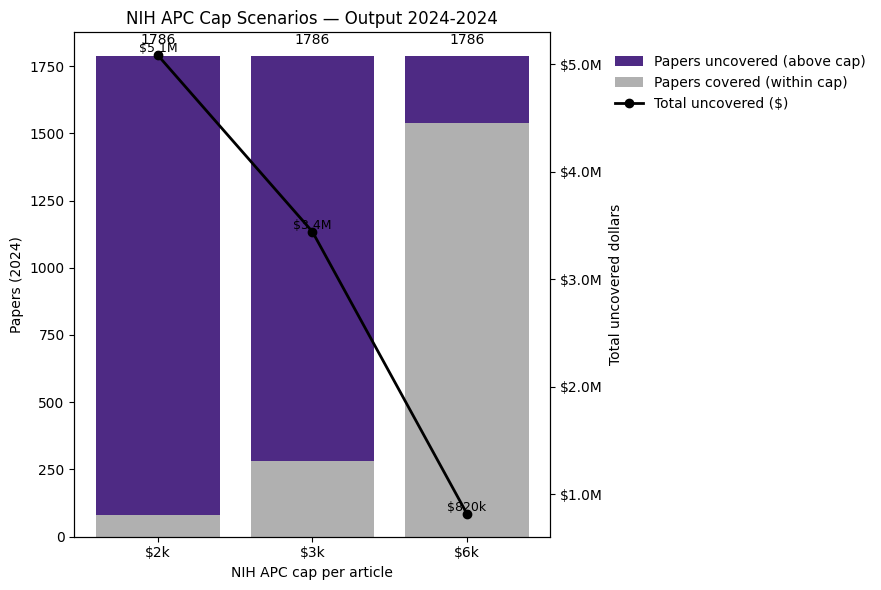

Saved chart -> scenario_overview.png


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# --- Load the one-row-per-scenario summary your earlier script wrote
df = pd.read_csv("2024/all_scenarios_summary.csv")

# Sort scenarios by cap (just in case)
df = df.sort_values("cap_usd").reset_index(drop=True)

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# --- colors
PURPLE = "#4E2A84"   # deep purple for uncovered
GREY   = "#B0B0B0"   # grey for covered
BLACK  = "#000000"   # black for line

x = np.arange(len(df))
xtick_labels = df["cap_usd"].apply(lambda x: f"${int(x/1000)}k")
within = df["papers_in_within_cap_journals"].astype(int)
above  = df["papers_in_above_cap_journals"].astype(int)
total_uncovered = df["total_uncovered_usd"].astype(float)

fig, ax = plt.subplots(figsize=(9, 6))

# Bars: covered (bottom, grey) + uncovered (top, purple)
bar_covered   = ax.bar(x, within, label="Papers covered (within cap)", color=GREY)
bar_uncovered = ax.bar(x, above, bottom=within, label="Papers uncovered (above cap)", color=PURPLE)

# Line: total uncovered dollars (black)
ax2 = ax.twinx()
line_uncovered, = ax2.plot(x, total_uncovered, marker="o", linewidth=2, color=BLACK,
                           label="Total uncovered ($)", zorder=5)

# Axes/labels
ax.set_xticks(x)
ax.set_xticklabels(xtick_labels)
ax.set_xlabel("NIH APC cap per article")
ax.set_ylabel("Papers (2024)")

def money_fmt(y, _):
    if y >= 1_000_000: return f"${y/1_000_000:.1f}M"
    if y >= 1_000:     return f"${y/1_000:.0f}k"
    return f"${int(y)}"

ax2.yaxis.set_major_formatter(FuncFormatter(money_fmt))
ax2.set_ylabel("Total uncovered dollars")

years = df.get("years_considered", pd.Series(["2024"])).iloc[0]
ax.set_title(f"NIH APC Cap Scenarios — Output {years}")

# Annotations
totals = (within + above).values
for i, t in enumerate(totals):
    ax.text(x=i, y=t + max(totals)*0.02, s=str(t), ha="center", va="bottom", fontsize=10)
for i, val in enumerate(total_uncovered):
    ax2.text(x=i, y=val, s=money_fmt(val, None), ha="center", va="bottom", fontsize=9)

# Legend outside (right side)
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = [bar_uncovered, bar_covered, line_uncovered]  # order as requested
labels  = ["Papers uncovered (above cap)", "Papers covered (within cap)", "Total uncovered ($)"]

plt.subplots_adjust(right=0.74)  # leave space on the right
ax.legend(handles, labels, loc="center left",
          bbox_to_anchor=(1.11, 0.9), frameon=False)
#ax.legend(handles, labels, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

plt.tight_layout()
plt.savefig("scenario_overview.png", dpi=200, bbox_inches="tight")
plt.show()

print("Saved chart -> scenario_overview.png")
